<a href="https://colab.research.google.com/github/janinerottmann/ITM22/blob/main/%C3%9Cbung3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IT Management\
Janine Rottmann\
Lehrstuhl für Wirtschaftsinformatik und Systementwicklung

---

# **Process Mining with Python tutorial: A healthcare application - Part 1**

# 1. Introduction

### 1.1 Process mining in healthcare

In recent years, digitisation of healthcare records and systemetisation of healthcare processes has resulted in the generation of more and more data from complex healthcare processes. There has also been growing interest in using process mining techniques to optimise and debug processes to improve the quality and efficiency of care. Such techniques have been used to:


*   Discover processes and characterise them in process models. Different graphical languages such as petri nets, directly-follows graphs and business process models might be used to represent such models.

*   Discover bottlenecks and identifying opportunities for improving efficiency by analysing throughput and the time spent on each event.

*   Determine to what extent real processes adhere to those in good practice guidelines and treatment pathways.

### 1.2 What is a process?

In process mining, a process is sequence of events (discrete actions) that are executed to reach a particular goal or outcome. For example, we can characterise each patient’s hospital journey as a process, starting from when they are admitted to when they are discharged. Everything that happens to them in the hospital is an event that makes up this process.

### 1.3 Establishing cases, events and resources

For the purposes of process mining, an event log must contain:
case identifiers, which track entities through the events of a process, e.g. patient id, doctor id;
event names/descriptions/identifiers, which give us a handle on the event types that feature in the processes;
time stamps (associated with each event), which allow us to determine the order and duration of events.
Optionally, you will also have resources associated with each event, e.g. the equipment or medical professional involved. Event attributes other than timestamps and resources are also possible, e.g. transactional information, costs. Attributes are also possible for cases, e.g. patient age, diagnosis, outcome, flow time, contextual attributes.
The first thing to establish is what we are trying to find out and which columns we are treating as the cases, events and (optionally) resources. From this you’ll then be able to decide which column you are treating as the case, which you are treating as the event, and which you are treating as the resource (optional).




# 2. Let's get started!

First we need to install the required libraries for this task and download the event log.

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download the event log data.
events = pd.read_csv("https://raw.githubusercontent.com/janinerottmann/ITM22/main/data/ArtificialPatientTreatment.csv?token=GHSAT0AAAAAABTBSHYGBC5WHVIR63BFAQSOYSNYA5Q")
events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [ ]:
print('Event log has {} rows and {} columns.'.format(events.shape[0], events.shape[1]))

Event log has 690 rows and 4 columns.


Let’s say our objective is to better undertand the different journeys that patients go through, cases would be associated with the patient column, events with the action column, and resources with the resource column (but if we had a different objective, we might need to choose a different mapping, e.g. we might treat the resource column as the case if we were studying the processes from the perspective of medical practitioners rather than patients).

# 3. Preparing and exploring the event log
A first step in preparing the event log is to calculate the relative time of each event, which is time the event occurs with respect to the beginning of the process.

In [ ]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


To get an initial feel for what processes ‘look like’, it is useful to visualise the events associated with each case over (relative) time. This can be done with what is known in the process mining community as a ‘dotted chart’. You can implement this using a scatter plot or strip plot in Python, which plots the event sequences of each case against time.


([<matplotlib.axis.YTick at 0x7f13def0b890>,
 <a list of 20 Text major ticklabel objects>)

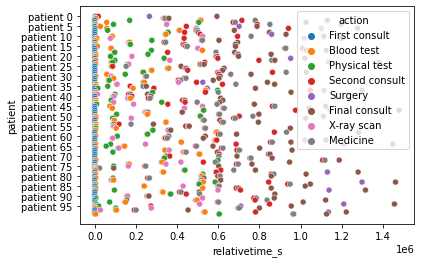

In [ ]:
## Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]
## Plot a scatter plot of patient events over relative time
ax = sns.scatterplot(x=events['relativetime_s'],
y=events['patient'], hue=events['action'])
## Set y axis ticks so that you only show every 5th patient - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))

This is quite difficult to read. To make the plot easier to read, we should order the cases by overall process lengths. This also gives you a better feel for the distribution of process durations.

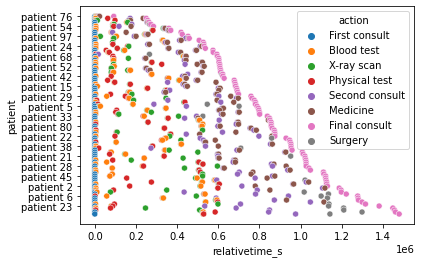

In [ ]:
## Order by the case length
ordered = events.sort_values(by=['caselength', 'patient', 'relativetime_s'])
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5)); 
plt.show()

The dotted chart can also be used to get an idea of the event flow over absolute time, e.g. if cases are coming in regularly, if there are weekly or daily trends.


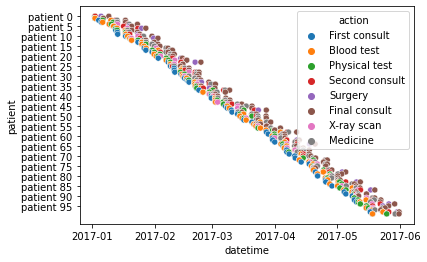

In [ ]:
ax = sns.scatterplot(x=events['datetime'], y=events['patient'], hue=events['action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

This shows a steady flow of cases over time.
You can also study events with respect to the resources by plotting events with respect to them.

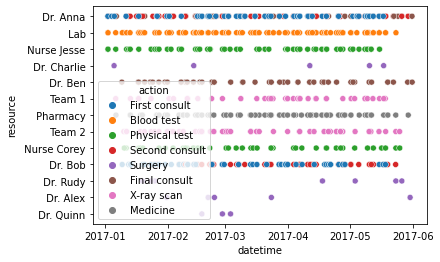

In [ ]:
ax = sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])

To investigate weekly trends, you first need to convert the time stamps into days of the week.

In [ ]:
## Get day of week 
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())

This time you should use a jitter plot rather than a strip plot because the x axis (day of week) is categorical.

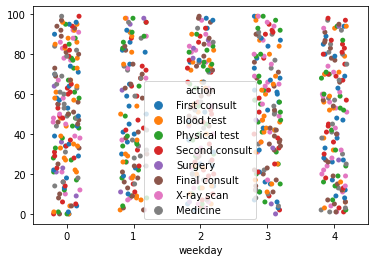

In [ ]:
## Strip plot
ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events['action'], jitter=0.2)

## 4. Filtering events

One final thing you might want to look at is which events are shared by all processes and which are not, since in process mining it is the non-shared differentiating events that we are interested in

The following actions are common to all cases: Blood test, Final consult, First consult, Physical test, Second consult
The following actions are the ones that we wish to keep (not common to all cases): Medicine, Surgery, X-ray scan


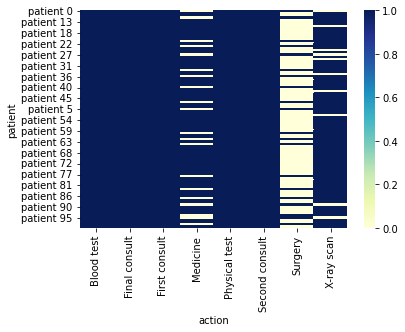

In [ ]:
## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(events['patient'], events['action']) 
## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")
## Calculate the number of unique event counts 
## This should be 1 for events which are shared by all patients.
nunique = patient_events.apply(pd.Series.nunique) 
## Identify the events which are shared by all 
shared_actions = nunique[nunique==1].index 
actions_to_keep = nunique[nunique>1].index 
print('The following actions are common to all cases: {}'.format(', '.join(shared_actions))) 
print('The following actions are the ones that we wish to keep (not common to all cases): {}'.format(', '.join(actions_to_keep)))

In this example, First consult, Blood test, Second consult, Physical test and Final consult are the events shared by all patients, while Medicine, Surgery and X-ray scan are the differentiating events.

# 5. Questions

1. What is the minimum number of events per case?



In [ ]:
print('Minimum number of events per case: {}'.format(min(events['patient'].value_counts())))

Minimum number of events per case: 6


2. Which doctors did patient 26 have his/her first and last consultation with?

In [ ]:
first_doctor = events[events['datetime']==min(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
last_doctor = events[events['datetime']==max(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
print('First doctor: {}'.format(first_doctor))
print('Last doctor: {}'.format(last_doctor))

First doctor:  Dr. Bob
Last doctor:  Dr. Ben


3. Which activity has the lowest occurrence overall in the event log?

In [ ]:
print('Activity with lowest occurrence: {}'.format(events['action'].value_counts().sort_values().idxmin()))

Activity with lowest occurrence: Surgery


In [ ]:
activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']
assert(len(activities)==len(markers))
patients = events['patient'].unique()
selected_patients = patients[0:50]
patientX = events[events['patient'].isin(selected_patients)]